# Import Modules and Pickle File

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from datetime import datetime
import re
import random
import gc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'axes.titleweight': 'bold',
          'axes.labelweight': 'bold',
          'xtick.labelsize':'xx-large',
          'xtick.major.size': 5.5,
          'ytick.labelsize':'xx-large',
          'ytick.major.size': 5.5,
          'axes.labelpad': 15.0,
          'grid.color': 'gray',
          'axes.edgecolor': 'black'}
pylab.rcParams.update(params)
plt.rcParams["patch.force_edgecolor"] = True

In [2]:
file = '/Users/charisameeker/Documents/Data/iowa_liquor_clean1.9.csv'
df = pd.read_csv(file,
        parse_dates = ['date'],
        dtype = {'year':np.int16, 'month':np.int8, 'day':np.int8,
        'store_number':np.int16, 'county_number':np.int8, 'item_number':np.int32,
        'pack':np.int16, 'bottle_vol':np.int64, 'bottle_cost':np.float32,
        'state_bottle_retail':np.float32, 'bottles_sold':np.int16, 'sale':np.float32,
        'vol_sold':np.float32, 'bottles_sold':np.int16,
        'category':np.int32
        })

In [3]:
# These columns aren't useful for our machine models.
df.drop(['Unnamed: 0', 'store_location', 'coordinates', 'stores_subname'], axis=1, inplace=True)

In [4]:
df.dtypes

date                   datetime64[ns]
year                            int16
month                            int8
day                              int8
store_number                    int16
store_name                     object
address                        object
city                           object
zip_code                      float64
county_number                    int8
county                         object
category                        int32
category_name                  object
vendor_number                 float64
vendor_name                    object
item_number                     int32
item_description               object
pack                            int16
bottle_vol                      int64
bottle_cost                   float32
state_bottle_retail           float32
bottles_sold                    int16
sale                          float32
vol_sold                      float32
store_subname                  object
store_subnumber                object
dtype: objec

# I. Missing Values

In [5]:
def nan_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
    missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
    print(missing_data[missing_data['Total'] > 0].round({'Missing Percent': 3}))
    
nan_percentage(df)

                   Total  Missing Percent
store_subnumber  8584472           68.179
store_subname    4290853           34.079
county             79178            0.629
category_name       8024            0.064
zip_code            2420            0.019
address             2376            0.019
city                2375            0.019
vendor_number          3            0.000
vendor_name            1            0.000


## Let's address these in descending order, and then the columns especially related to sales, which has many 0 values.

## I.1 Our new columns store_subnumber and store_subname have many missing values. We cannot recover any of those values (or be sure they exist for every store).

In [6]:
df.store_subnumber.shape[0] - df.store_subnumber.str.isnumeric().sum()

9167469

In [7]:
df.query('store_subnumber == 100').shape[0]

0

### There are many non-numeric values, and no values of 100 (our standard NaN number). So we'll convert them to numerics then fill the NaNs with 100.

In [8]:
df['store_subnumber'] = pd.to_numeric(df['store_subnumber'], errors='coerce', downcast='integer')
df['store_subnumber'].dtype

dtype('float64')

In [9]:
df.store_subnumber = df.store_subnumber.fillna(100)

In [10]:
df.store_subnumber = df.store_subnumber.astype('int16')

### store_subname will be replaced with strings: 'nan'

In [11]:
df.store_subname = df.store_subname.fillna('nan')

## I.2 The county_number and county columns still have unrecoverable information
## I.3 category_name

In [12]:
df.county = df.county.fillna('nan')

In [13]:
df.category_name = df.category_name.fillna('nan')

## I.4 The address column has one value that is able to be found and inserted by a quick query via a search engine.
## - Otherwise, the columns address, city, and coordinates are strings and so will have 'nan' inserted.

In [14]:
df.query('address.isna() & city.notna()', engine='python')

,date,year,month,day,store_number,store_name,address,city,zip_code,county_number,...,item_description,pack,bottle_vol,bottle_cost,state_bottle_retail,bottles_sold,sale,vol_sold,store_subname,store_subnumber
11755302,2017-06-22,2017,6,22,9932,"3-oaks distillery, llc",NaN,dubuque,520020.0,31,...,3-oaks distillery whiskey,12,750,21.6,32.400002,1,388.799988,0.75,nan,100


In [15]:
df.address[11755302] = '23039 Pfeiler Rd'

<ipython-input-15-33951e80f189>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.address[11755302] = '23039 Pfeiler Rd'


In [16]:
df.sale.isna().sum()

0

In [17]:
df.address = df.address.fillna('nan')
df.city = df.city.fillna('nan')
df.category_name = df.category_name.fillna('nan')
df.zip_code = df.zip_code.fillna(100)

## I.5 sale-related Columns:
 - state_bottle_retail
 - bottle_cost
 - sale
### I converted the NaN values of the sale-related columns to 0. They cannot stay 0 because they will be subject to mathematical operations. The median is a safe bet, especially because they constitute far less than 1% of the data.

In [18]:
print(df.query('state_bottle_retail == 0 | bottle_cost == 0 | sale == 0').shape[0],
'rows of the above contain zero. They were NaN before converted to 0.',
'\n', df.query('bottle_cost == 0 & sale == 0').shape[0], 'rows contain NaNs for all three columns: state_bottle_retail, bottle_cost, sale.',
'\n\t-', df.query('state_bottle_retail == 0').shape[0], 'rows are state_bottle_retail.',
'\n\t-', df.query('bottle_cost == 0').shape[0], 'rows are bottle_cost.',
'\n\t-', df.query('state_bottle_retail == 0 & bottle_cost == 0').shape[0], 'rows are both state_bottle_retail and bottle_cost.'
'\n', df.query('sale == 0').shape[0], 'rows are sale alone, with',
      df.query('sale == 0 & bottle_cost != 0').shape[0],'more than the other factors.')

4316 rows of the above contain zero. They were NaN before converted to 0. 
 3094 rows contain NaNs for all three columns: state_bottle_retail, bottle_cost, sale. 
	- 3094 rows are state_bottle_retail. 
	- 3094 rows are bottle_cost. 
	- 3094 rows are both state_bottle_retail and bottle_cost.
 4316 rows are sale alone, with 1222 more than the other factors.


In [19]:
# Convert to NaN
df.state_bottle_retail = df.state_bottle_retail.replace(0, np.nan)
df.bottle_cost = df.bottle_cost.replace(0, np.nan)
df.sale = df.sale.replace(0, np.nan)

In [20]:
imr = SimpleImputer(strategy='median')
imr = imr.fit(df[['state_bottle_retail']])
df.state_bottle_retail = imr.transform(df[['state_bottle_retail']]).ravel()

In [21]:
imr = SimpleImputer(strategy='median')
imr = imr.fit(df[['bottle_cost']])
df.bottle_cost = imr.transform(df[['bottle_cost']]).ravel()

In [22]:
imr = SimpleImputer(strategy='median')
imr = imr.fit(df[['sale']])
df.sale = imr.transform(df[['sale']]).ravel()

## I.6 vendor_name and vendor_number

In [23]:
pd.set_option('display.max_columns', None)
df.query('vendor_number.isna()', engine='python')

,date,year,month,day,store_number,store_name,address,city,zip_code,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_vol,bottle_cost,state_bottle_retail,bottles_sold,sale,vol_sold,store_subname,store_subnumber
10188726,2016-10-17,2016,10,17,2190,"central city liquor, inc.",1460 2nd ave,des moines,50314.0,77,polk,1011300,single barrel bourbon whiskies,NaN,reservoir distillery,916456,reservoir bourbon whiskey,6,750,45.00,67.500000,5,405.000000,3.75,nan,100
10188727,2016-10-17,2016,10,17,2190,"central city liquor, inc.",1460 2nd ave,des moines,50314.0,77,polk,1091100,american distilled spirit specialty,NaN,reservoir distillery,927565,reservoir wheat whiskey,6,750,45.00,67.500000,3,405.000000,2.25,nan,100
11174263,2017-03-22,2017,3,22,2556,hy-vee wine and spirits,2608 e. central avenue,estherville,51334.0,32,emmet,100,nan,NaN,NaN,905433,laphroaig quarter cask,6,750,4.17,47.240002,1,283.440002,0.75,estherville,100


In [24]:
df.vendor_number = df.vendor_number.fillna(5)
df.vendor_name = df.vendor_name.replace(np.nan, 'nan')

In [25]:
df[df.vendor_name.str.contains('reservoir')]

,date,year,month,day,store_number,store_name,address,city,zip_code,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_vol,bottle_cost,state_bottle_retail,bottles_sold,sale,vol_sold,store_subname,store_subnumber
10188726,2016-10-17,2016,10,17,2190,"central city liquor, inc.",1460 2nd ave,des moines,50314.0,77,polk,1011300,single barrel bourbon whiskies,5.0,reservoir distillery,916456,reservoir bourbon whiskey,6,750,45.0,67.5,5,405.0,3.75,nan,100
10188727,2016-10-17,2016,10,17,2190,"central city liquor, inc.",1460 2nd ave,des moines,50314.0,77,polk,1091100,american distilled spirit specialty,5.0,reservoir distillery,927565,reservoir wheat whiskey,6,750,45.0,67.5,3,405.0,2.25,nan,100


### Ideally, because two of the three rows missing a vendor number have a vendor name, we would be able to derive those numbers from the vendor name by finding another row with the same vendor name ('reservoir bourbon whiskey') and impute the corresponding vendor number. Unfortunately, there is no other row with such a vendor name. The three missing values will stay missing. <br>
### 5 will be our secondary NaN number, as used above.

## Confirm No NaNs and Minimize dtypes

In [26]:
nan_percentage(df)

Empty DataFrame
Columns: [Total, Missing Percent]
Index: []


In [27]:
# numbers
df.zip_code = df.zip_code.astype('int16')
df.vendor_number = df.vendor_number.astype('int16')

# object/string
df.store_name = df.store_name.astype('str')
df.address = df.address.astype('str')
df.city = df.city.astype('str')
df.county = df.county.astype('str')
df.category_name = df.category_name.astype('str')
df.vendor_name = df.vendor_name.astype('str')
df.item_description = df.item_description.astype('str')
df.store_subname = df.store_subname.astype('str')

In [28]:
df.dtypes

date                   datetime64[ns]
year                            int16
month                            int8
day                              int8
store_number                    int16
store_name                     object
address                        object
city                           object
zip_code                        int16
county_number                    int8
county                         object
category                        int32
category_name                  object
vendor_number                   int16
vendor_name                    object
item_number                     int32
item_description               object
pack                            int16
bottle_vol                      int64
bottle_cost                   float32
state_bottle_retail           float32
bottles_sold                    int16
sale                          float32
vol_sold                      float32
store_subname                  object
store_subnumber                 int16
dtype: objec

### Memory

In [29]:
print('Memory Usage (Deep=True) (GB):',
      np.round(df.memory_usage(deep=True).sum() / 10 ** 9, decimals=2),
    '\nMemory Usage (Deep=False) (GB):',
      np.round(df.memory_usage(deep=False).sum() / 10 ** 9, decimals=2))

Memory Usage (Deep=True) (GB): 7.86 
Memory Usage (Deep=False) (GB): 1.52


# EDA

## Preparing for FB Prophet Analysis
### I actually perform this analysis on a different notebook

In [30]:
proph_d = {'ds': df.date, 'y': df.sale}
df_prophet = pd.DataFrame(data=proph_d)
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12591077 entries, 0 to 12591076
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ds      datetime64[ns]
 1   y       float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 144.1 MB


In [31]:
# file = '/Users/charisameeker/Documents/Data/iowa_liquor_prophet.csv'
# df_prophet.to_csv(file, index=False)

# EDA Sales Graphs

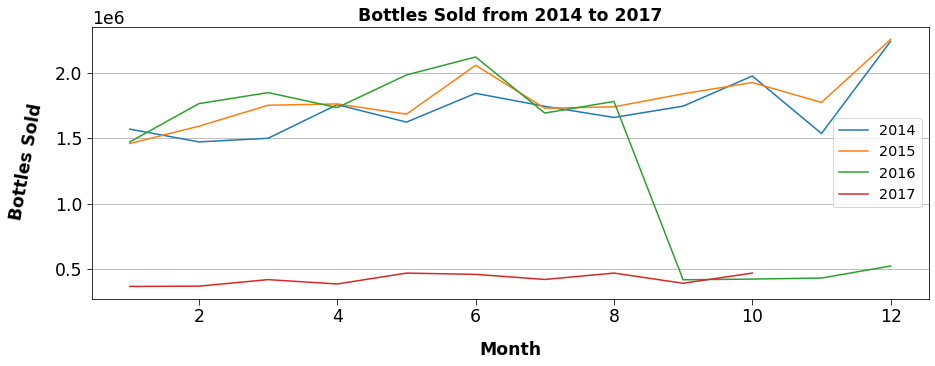

In [32]:
df.query('year == 2014').groupby('month').bottles_sold.sum().plot(label='2014')
df.query('year == 2015').groupby('month').bottles_sold.sum().plot(label='2015')
df.query('year == 2016').groupby('month').bottles_sold.sum().plot(label='2016')
df.query('year == 2017').groupby('month').bottles_sold.sum().plot(label='2017')
plt.title('Bottles Sold from 2014 to 2017')
plt.xlabel('Month'), plt.xticks(rotation=0)
plt.ylabel('Bottles Sold',rotation=80,labelpad=20), plt.legend()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

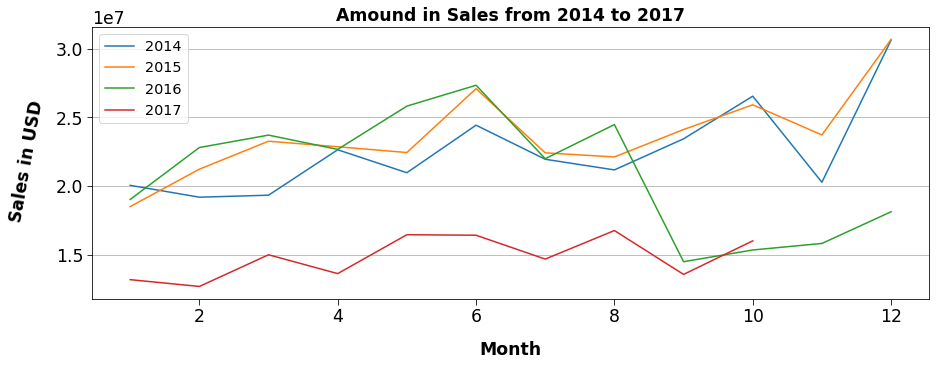

In [33]:
df.query('year == 2014').groupby('month').sale.sum().plot(label='2014')
df.query('year == 2015').groupby('month').sale.sum().plot(label='2015')
df.query('year == 2016').groupby('month').sale.sum().plot(label='2016')
df.query('year == 2017').groupby('month').sale.sum().plot(label='2017')
plt.title('Amound in Sales from 2014 to 2017')
plt.xlabel('Month'), plt.xticks(rotation=0)
plt.ylabel('Sales in USD',rotation=80,labelpad=20), plt.legend()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

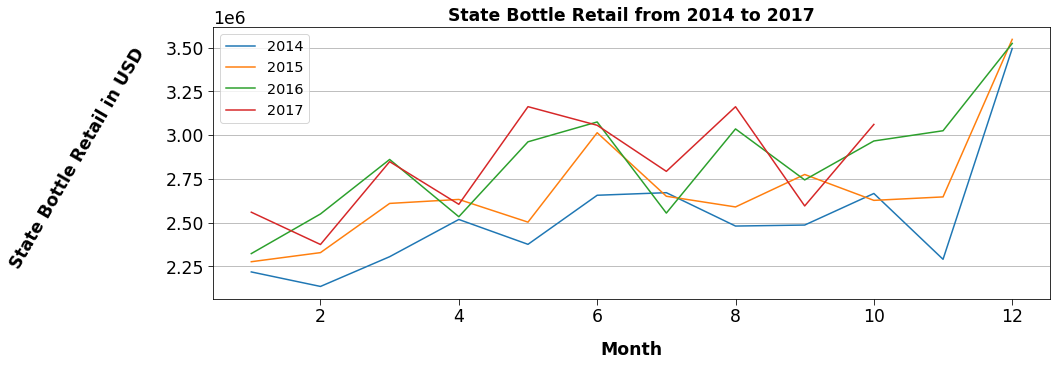

In [34]:
df.query('year == 2014').groupby('month').state_bottle_retail.sum().plot(label='2014')
df.query('year == 2015').groupby('month').state_bottle_retail.sum().plot(label='2015')
df.query('year == 2016').groupby('month').state_bottle_retail.sum().plot(label='2016')
df.query('year == 2017').groupby('month').state_bottle_retail.sum().plot(label='2017')
plt.title('State Bottle Retail from 2014 to 2017')
plt.xlabel('Month'), plt.xticks(rotation=0)
plt.ylabel('State Bottle Retail in USD',rotation=60,labelpad=80), plt.legend()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

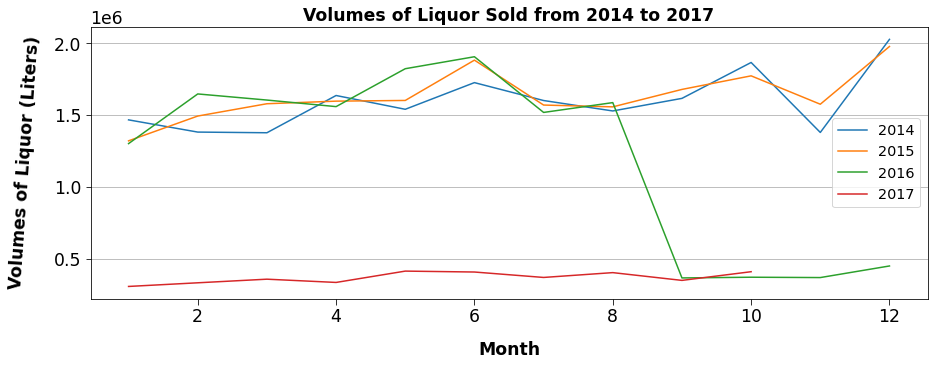

In [35]:
df.query('year == 2014').groupby('month').vol_sold.sum().plot(label='2014')
df.query('year == 2015').groupby('month').vol_sold.sum().plot(label='2015')
df.query('year == 2016').groupby('month').vol_sold.sum().plot(label='2016')
df.query('year == 2017').groupby('month').vol_sold.sum().plot(label='2017')
plt.title('Volumes of Liquor Sold from 2014 to 2017')
plt.xlabel('Month'), plt.xticks(rotation=0)
plt.ylabel('Volumes of Liquor (Liters)',rotation=86,labelpad=20), plt.legend()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

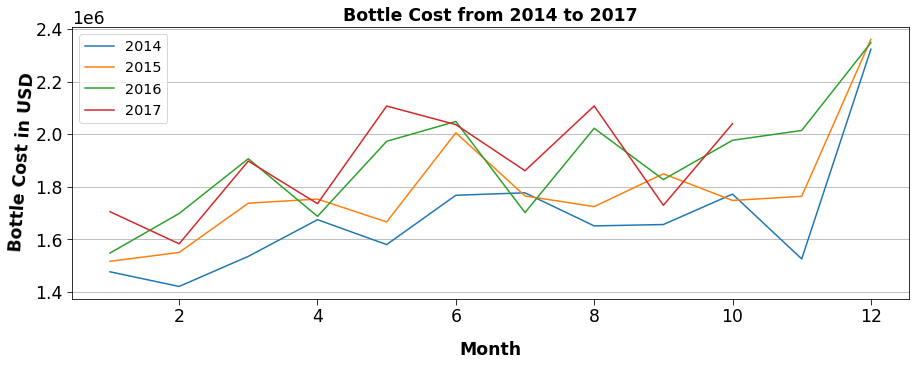

In [36]:
df.query('year == 2014').groupby('month').bottle_cost.sum().plot(label='2014')
df.query('year == 2015').groupby('month').bottle_cost.sum().plot(label='2015')
df.query('year == 2016').groupby('month').bottle_cost.sum().plot(label='2016')
df.query('year == 2017').groupby('month').bottle_cost.sum().plot(label='2017')
plt.title('Bottle Cost from 2014 to 2017')
plt.xlabel('Month'), plt.xticks(rotation=0)
plt.ylabel('Bottle Cost in USD',rotation=86,labelpad=4), plt.legend()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

## sales Distribution
### Let's use boxcox to cram it into a more normal distribution and compare the results.

In [37]:
fitted_data, fitted_lambda = stats.boxcox(df.sale)

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: overflow encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


In [49]:
df.insert(23, 'fd', fitted_data)

#### Normal distribution

(254100.0, 114.48125457763672, 377.7532958984375)

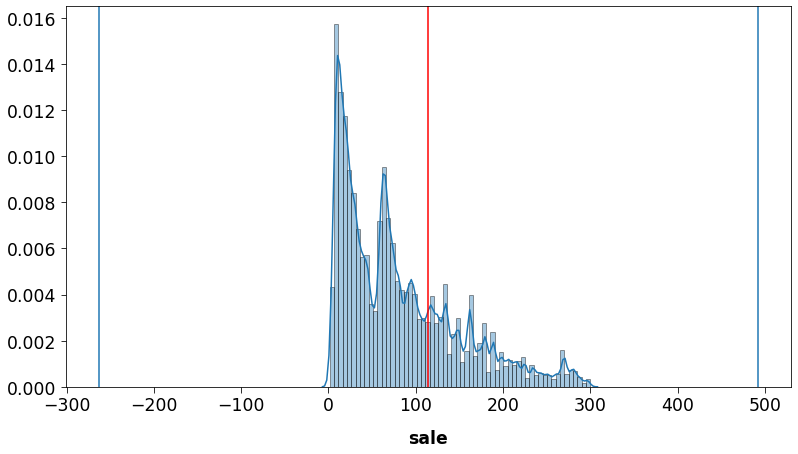

In [38]:
_ = plt.figure(figsize=(13, 7))
# _ = plt.xlim(0,300)
_ = sns.distplot(df.query('sale < 300')['sale'], bins=60)
_ = plt.axvline(np.mean(df.sale), c='r')
_ = plt.axvline(np.mean(df.sale) + np.std(df.sale))
_ = plt.axvline(np.mean(df.sale) - np.std(df.sale))
max(df.sale), np.mean(df.sale), np.std(df.sale)

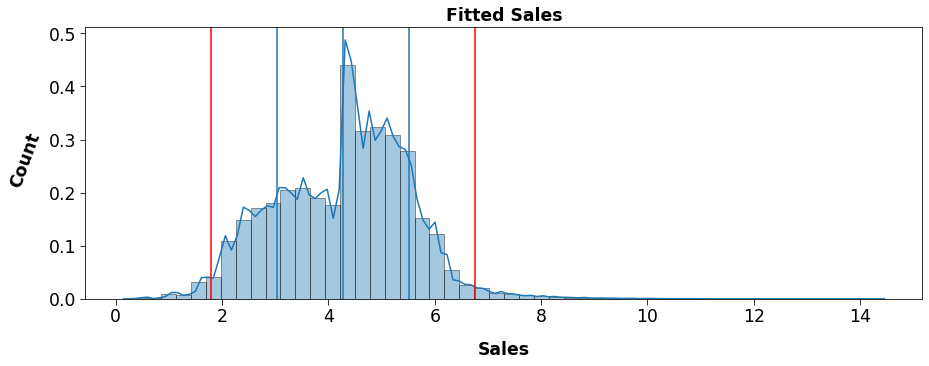

In [39]:
_ = sns.distplot(fitted_data)
_ = plt.axvline(np.mean(fitted_data) + np.std(fitted_data))
_ = plt.axvline(np.mean(fitted_data) + 2 * np.std(fitted_data), c='r')
_ = plt.axvline(np.mean(fitted_data) - np.std(fitted_data))
_ = plt.axvline(np.mean(fitted_data) - 2 * np.std(fitted_data), c='r')
_ = plt.axvline(np.mean(fitted_data))
_ = plt.title('Fitted Sales')
_ = plt.xlabel('Sales')
_ = plt.ylabel('Count', rotation=70)

In [58]:
print(f'Excess kurtosis of normal distribution (should be 0): {round(stats.kurtosis(df.sale), 2):,} \n\
Fitted Data: {round(stats.kurtosis(fitted_data), 2)}')

Excess kurtosis of normal distribution (should be 0): 44,774.07 
Fitted Data: 0.2


In [41]:
print(f'Coefficient of Variation: {round(stats.variation(df.sale), 2)} \n\
Fitted Data: {round(stats.variation(fitted_data), 2)}')

Coefficient of Variation: 3.299999952316284 
Fitted Data: 0.28999999165534973


In [42]:
# round with python or np don't work
print(f'Coefficient of Variation: {np.round(stats.variation(df.sale), decimals=2)}')

Coefficient of Variation: 3.299999952316284


In [43]:
print(f'Mean: {round(df.sale.mean(), 2)} \n \
STD: {round(np.std(df.sale), 2)}\n \
The STD being larger than the mean shows that the data has immense spread. \n\n\
Fitted Data\n\
\t Mean: {round(fitted_data.mean(), 2)} \n\
\t STD: {round(np.std(fitted_data), 2)}')

Mean: 114.48 
 STD: 377.75
 The STD being larger than the mean shows that the data has immense spread. 

Fitted Data
	 Mean: 4.28000020980835 
	 STD: 1.2400000095367432


In [44]:
Q1 = df.sale.quantile(0.25)
Q3 = df.sale.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR
print(f'Q1: {round(Q1, 2)} \n Q3: {round(Q3, 2)} \n IQR: {round(IQR, 2)} \n\
Upper: {round(upper, 2)}, \n Lower: {round(lower, 2)}')

# fitted data
Q1 = np.quantile(fitted_data, .25)
Q2 = np.quantile(fitted_data, .75)
# Q1 = fitted_data.quantile(0.25)
# Q3 = fitted_data.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR
print(f'\nFitted Data: \n\
Q1: {round(Q1, 2)} \n Q3: {round(Q3, 2)} \n IQR: {round(IQR, 2)} \n\
Upper: {round(upper, 2)}, \n Lower: {round(lower, 2)}')

Q1: 25.48 
 Q3: 132.72 
 IQR: 107.24 
Upper: 293.58, 
 Lower: -135.38

Fitted Data: 
Q1: 3.36 
 Q3: 132.72 
 IQR: 129.36 
Upper: 326.77, 
 Lower: -190.69


In [56]:
std_pos = df.sale[df.sale > (np.mean(df.sale + (2 * np.std(df.sale))))].count()
std_pos_fd = df.fd[df.fd > (np.mean(df.fd + (2 * np.std(df.fd))))].count()
#std_pos_fd = np.any(fitted_data > (np.mean(fitted_data) + (2 * np.std(fitted_data))),axis=0).sum()
#std_pos_fd_lc = [x.count() for x in fitted_data if x > (np.mean(fitted_data) + (2 * np.std(fitted_data)))]
print(f'Instances Two STDs above: {std_pos:,} \n\
Fitted Data: {std_pos_fd:,}')

Instances Two STDs above: 116,323 
Fitted Data: 221,282


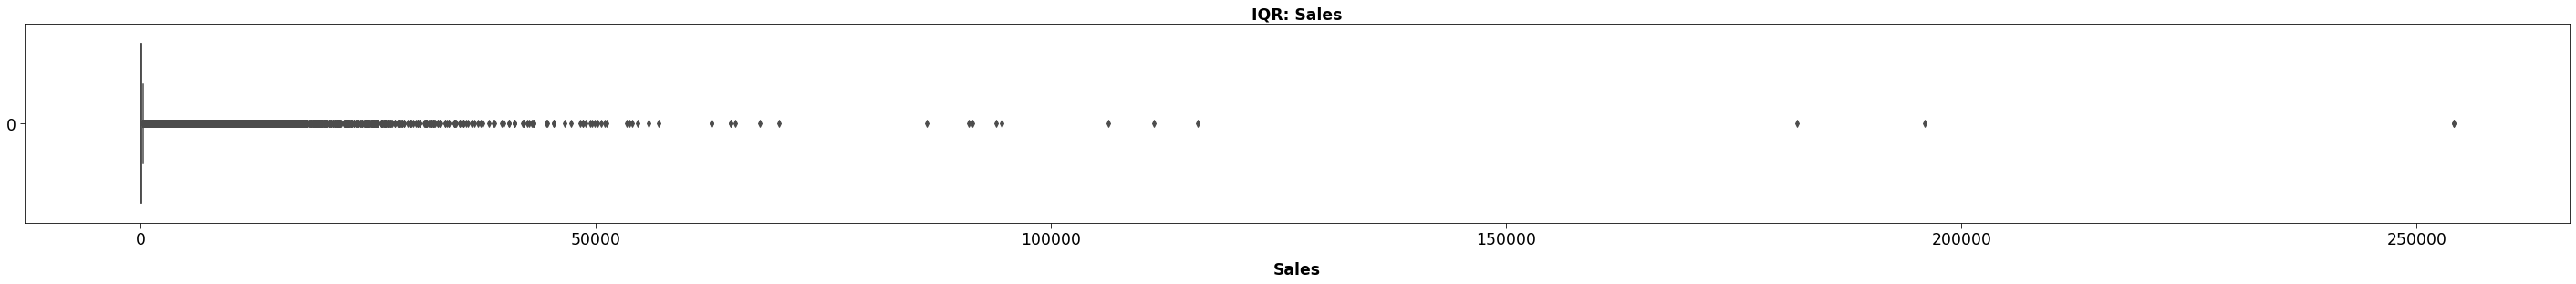

In [59]:
_ = plt.figure(figsize=(50, 4))
_ = sns.boxplot(data=df.sale, orient='h', color='cyan')
_ = plt.title('IQR: Sales')
_ = plt.xlabel('Sales')

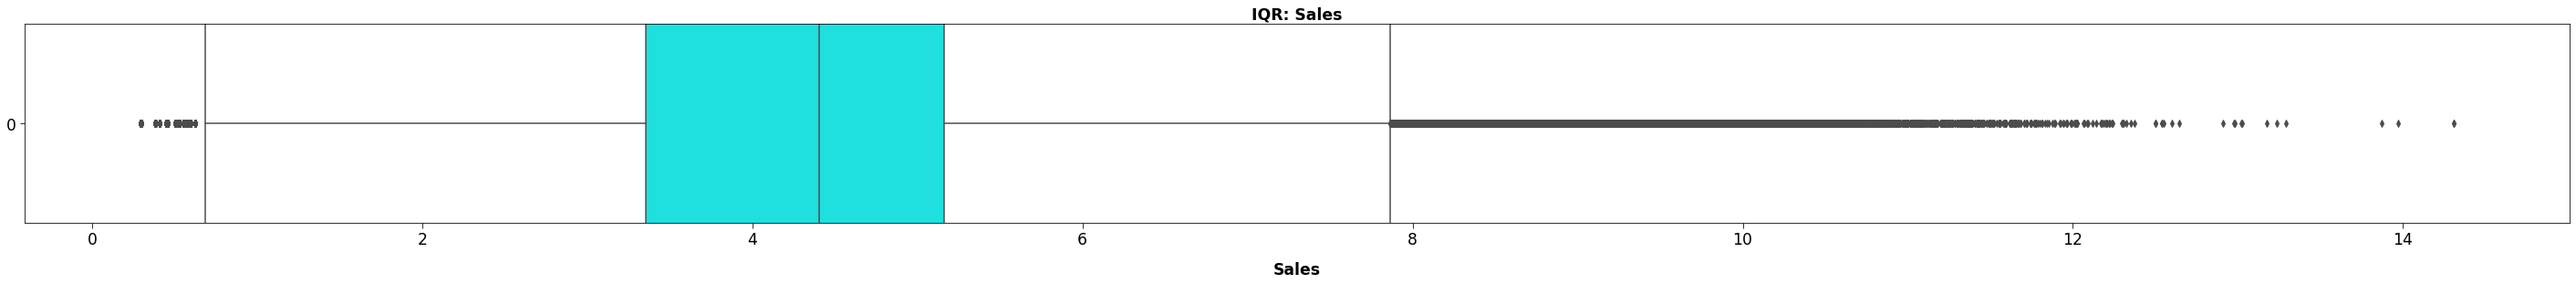

In [60]:
_ = plt.figure(figsize=(50, 4))
_ = sns.boxplot(data=fitted_data, orient='h', color='cyan', width = 8)
_ = plt.title('IQR: Sales')
_ = plt.xlabel('Sales')

#### Even longer figure (100, 4)

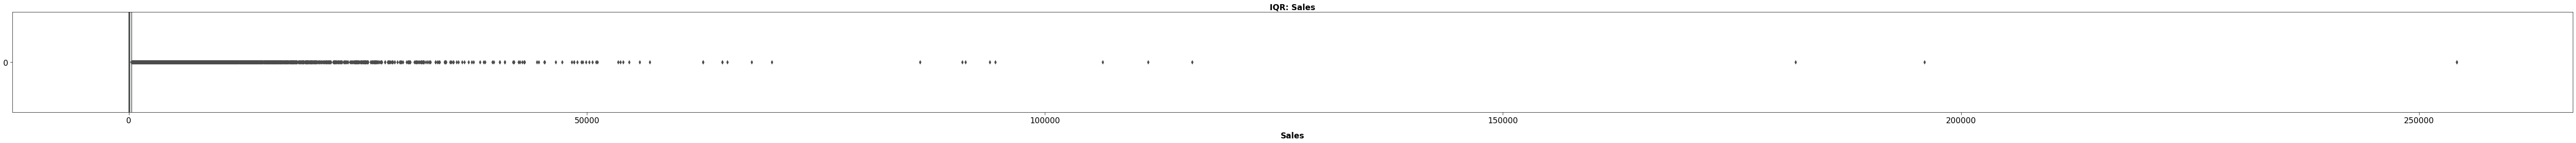

In [61]:
_ = plt.figure(figsize=(100, 4))
_ = sns.boxplot(data=df.sale, orient='h', color='cyan', width = 8)
_ = plt.title('IQR: Sales')
_ = plt.xlabel('Sales')

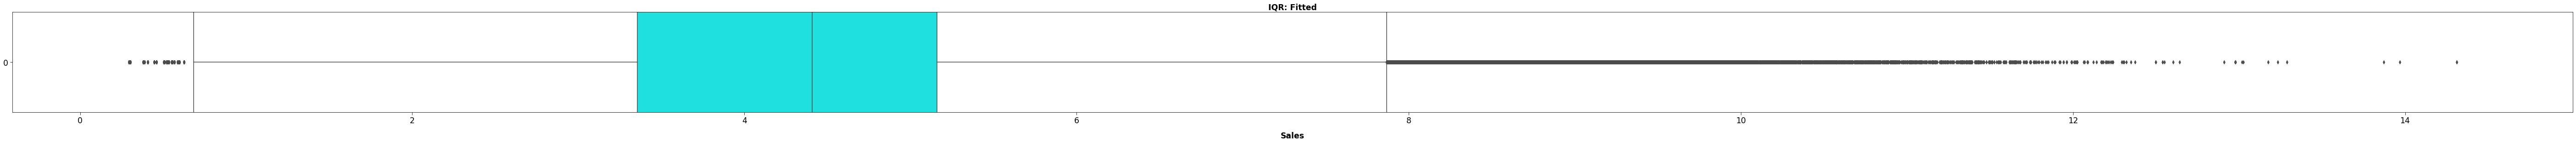

In [63]:
_ = plt.figure(figsize=(100, 4))
_ = sns.boxplot(data=df.fd, orient='h', color='cyan', width = 8)
_ = plt.title('IQR: Fitted')
_ = plt.xlabel('Sales')

## Categories

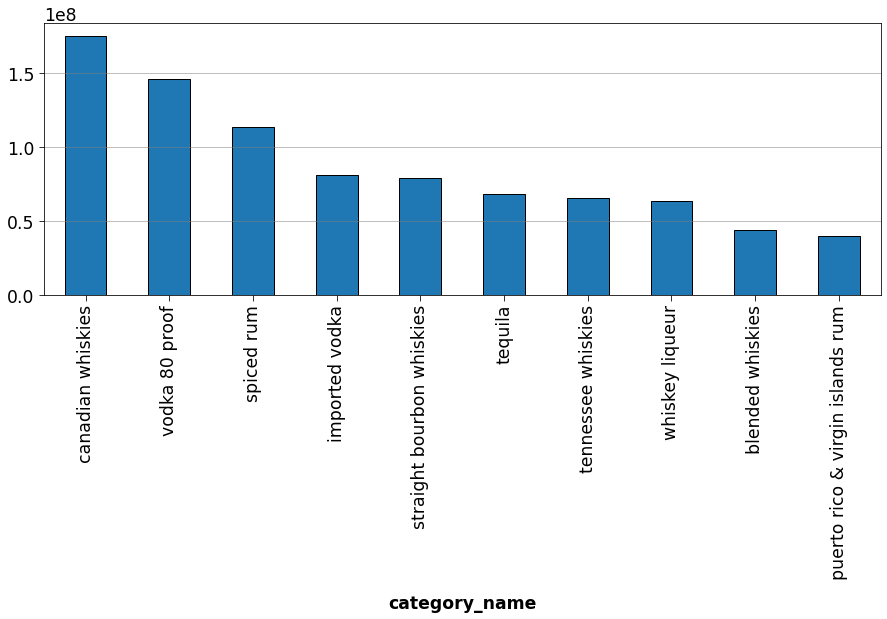

In [91]:
df1 = df.groupby('category_name').sale.sum().sort_values(ascending=False)
df1.head(10).plot.bar()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

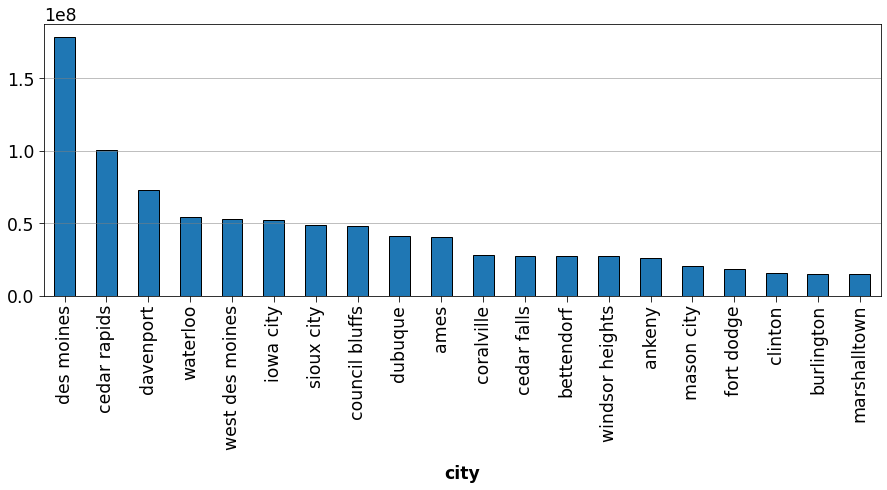

In [92]:
df2 = df.groupby('city').sale.sum().sort_values(ascending=False)
df2.head(20).plot.bar()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

In [102]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')
pd.plotting.output_notebook()

Loading BokehJS ...

Loading BokehJS ...

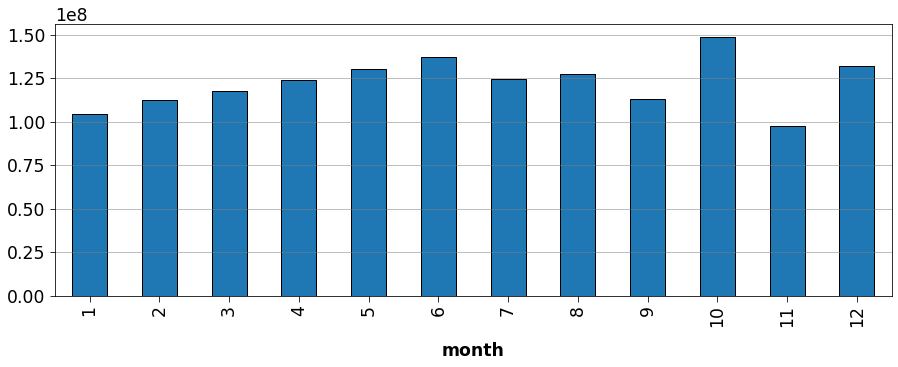

In [93]:
df_month = df.groupby('month').sale.sum()
df_month.plot.bar()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

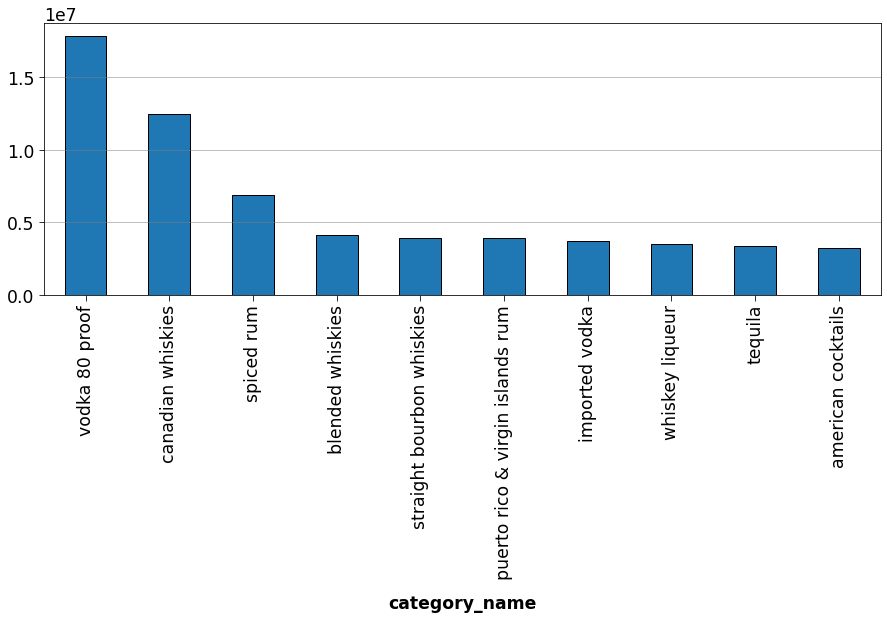

In [94]:
df_vol = df.groupby('category_name').vol_sold.sum().sort_values(ascending=False)
df_vol.head(10).plot.bar()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

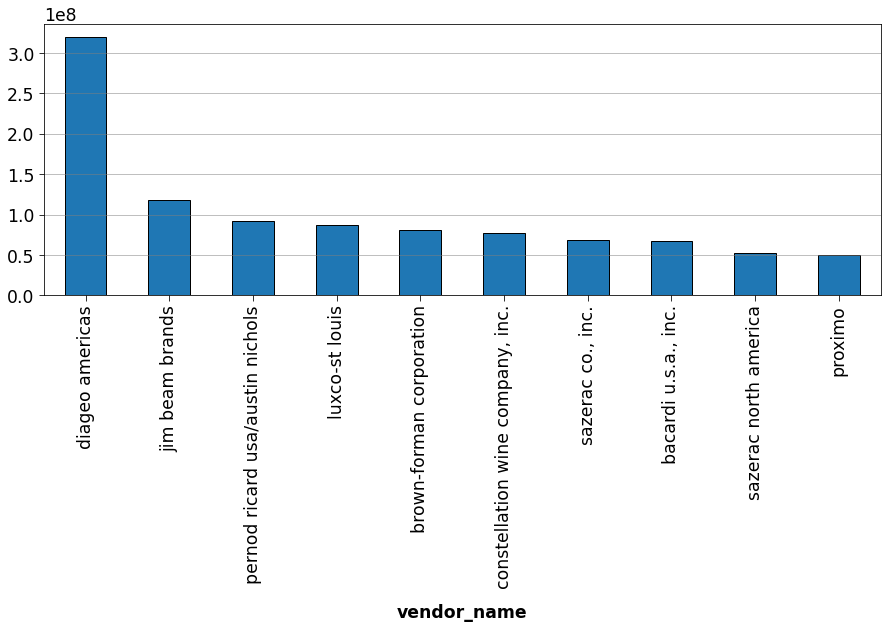

In [96]:
df_ven = df.groupby('vendor_name').sale.sum().sort_values(ascending=False)
df_ven.head(10).plot.bar()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

## Back to Sales
### Unsurprisingly, a correlation matrix doesn't teach us much.

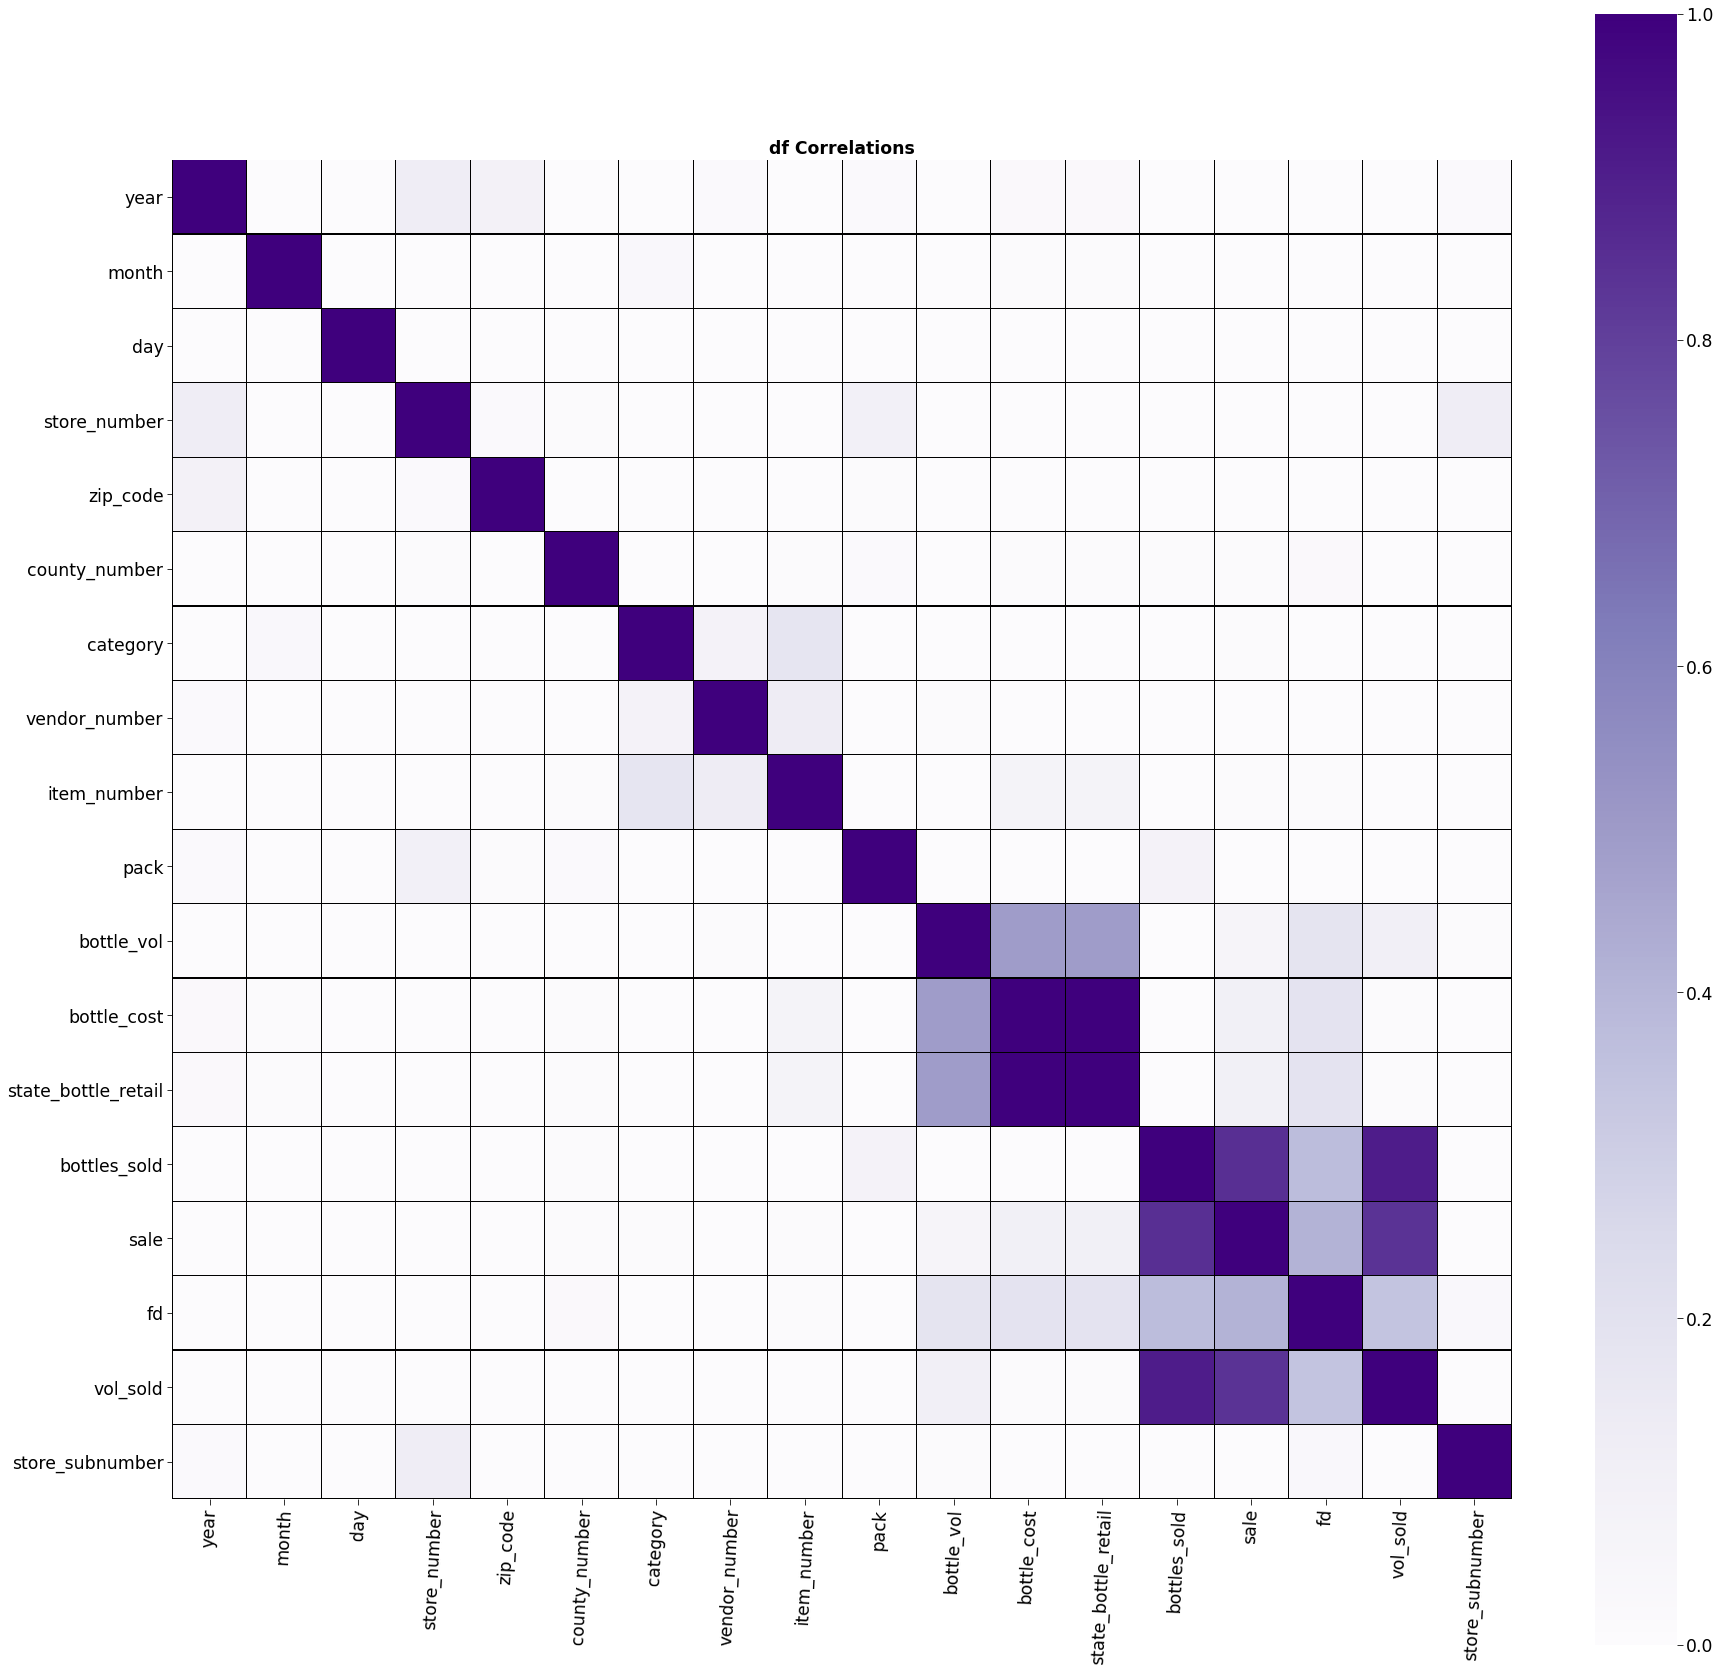

In [64]:
_ = plt.figure(figsize=(30, 30))
_ = sns.heatmap(df.corr(),square=True,vmin=0, vmax=1,cmap='Purples',linewidths=0.1,linecolor='k')
_ = plt.title('df Correlations')
_ = plt.xticks(rotation=87)

In [66]:
import ppscore as pps
matrix_df = pps.matrix(df.copy())[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

In [70]:
matrix_df.head()

x,address,bottle_cost,bottle_vol,bottles_sold,category,category_name,city,county,county_number,date,day,fd,item_description,item_number,month,pack,sale,state_bottle_retail,store_name,store_number,store_subname,store_subnumber,vendor_name,vendor_number,vol_sold,year,zip_code
y,,,,,,,,,,,,,,,,,,,,,,,,,,,
address,1.0,0.000883,0.00000,0.000000,0.000000,0.000000,0.245478,0.110806,0.108388,0.002641,0.0,0.002807,0.001518,0.002445,0.0,0.000000,0.002852,0.001306,0.456492,0.907786,0.246515,0.112912,0.000000,0.000000,0.000015,0.0,0.314844
bottle_cost,0.0,1.000000,0.07017,0.000000,0.156708,0.163503,0.000000,0.000000,0.000000,0.000000,0.0,0.351437,0.433387,0.804067,0.0,0.087092,0.347231,0.991994,0.000000,0.000000,0.000000,0.000000,0.104753,0.101491,0.000000,0.0,0.000000
bottle_vol,0.0,0.530030,1.00000,0.014947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.254720,0.261852,0.874833,0.0,0.495172,0.255513,0.541892,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.739809,0.0,0.000000
bottles_sold,0.0,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.358404,0.000000,0.000000,0.0,0.000000,0.357024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.793573,0.0,0.000000
category,0.0,0.300942,0.00000,0.000000,1.000000,0.983644,0.000000,0.000000,0.000000,0.000000,0.0,0.088104,0.780095,0.774543,0.0,0.000000,0.088869,0.326778,0.000000,0.000000,0.000000,0.000000,0.100716,0.113587,0.000000,0.0,0.000000


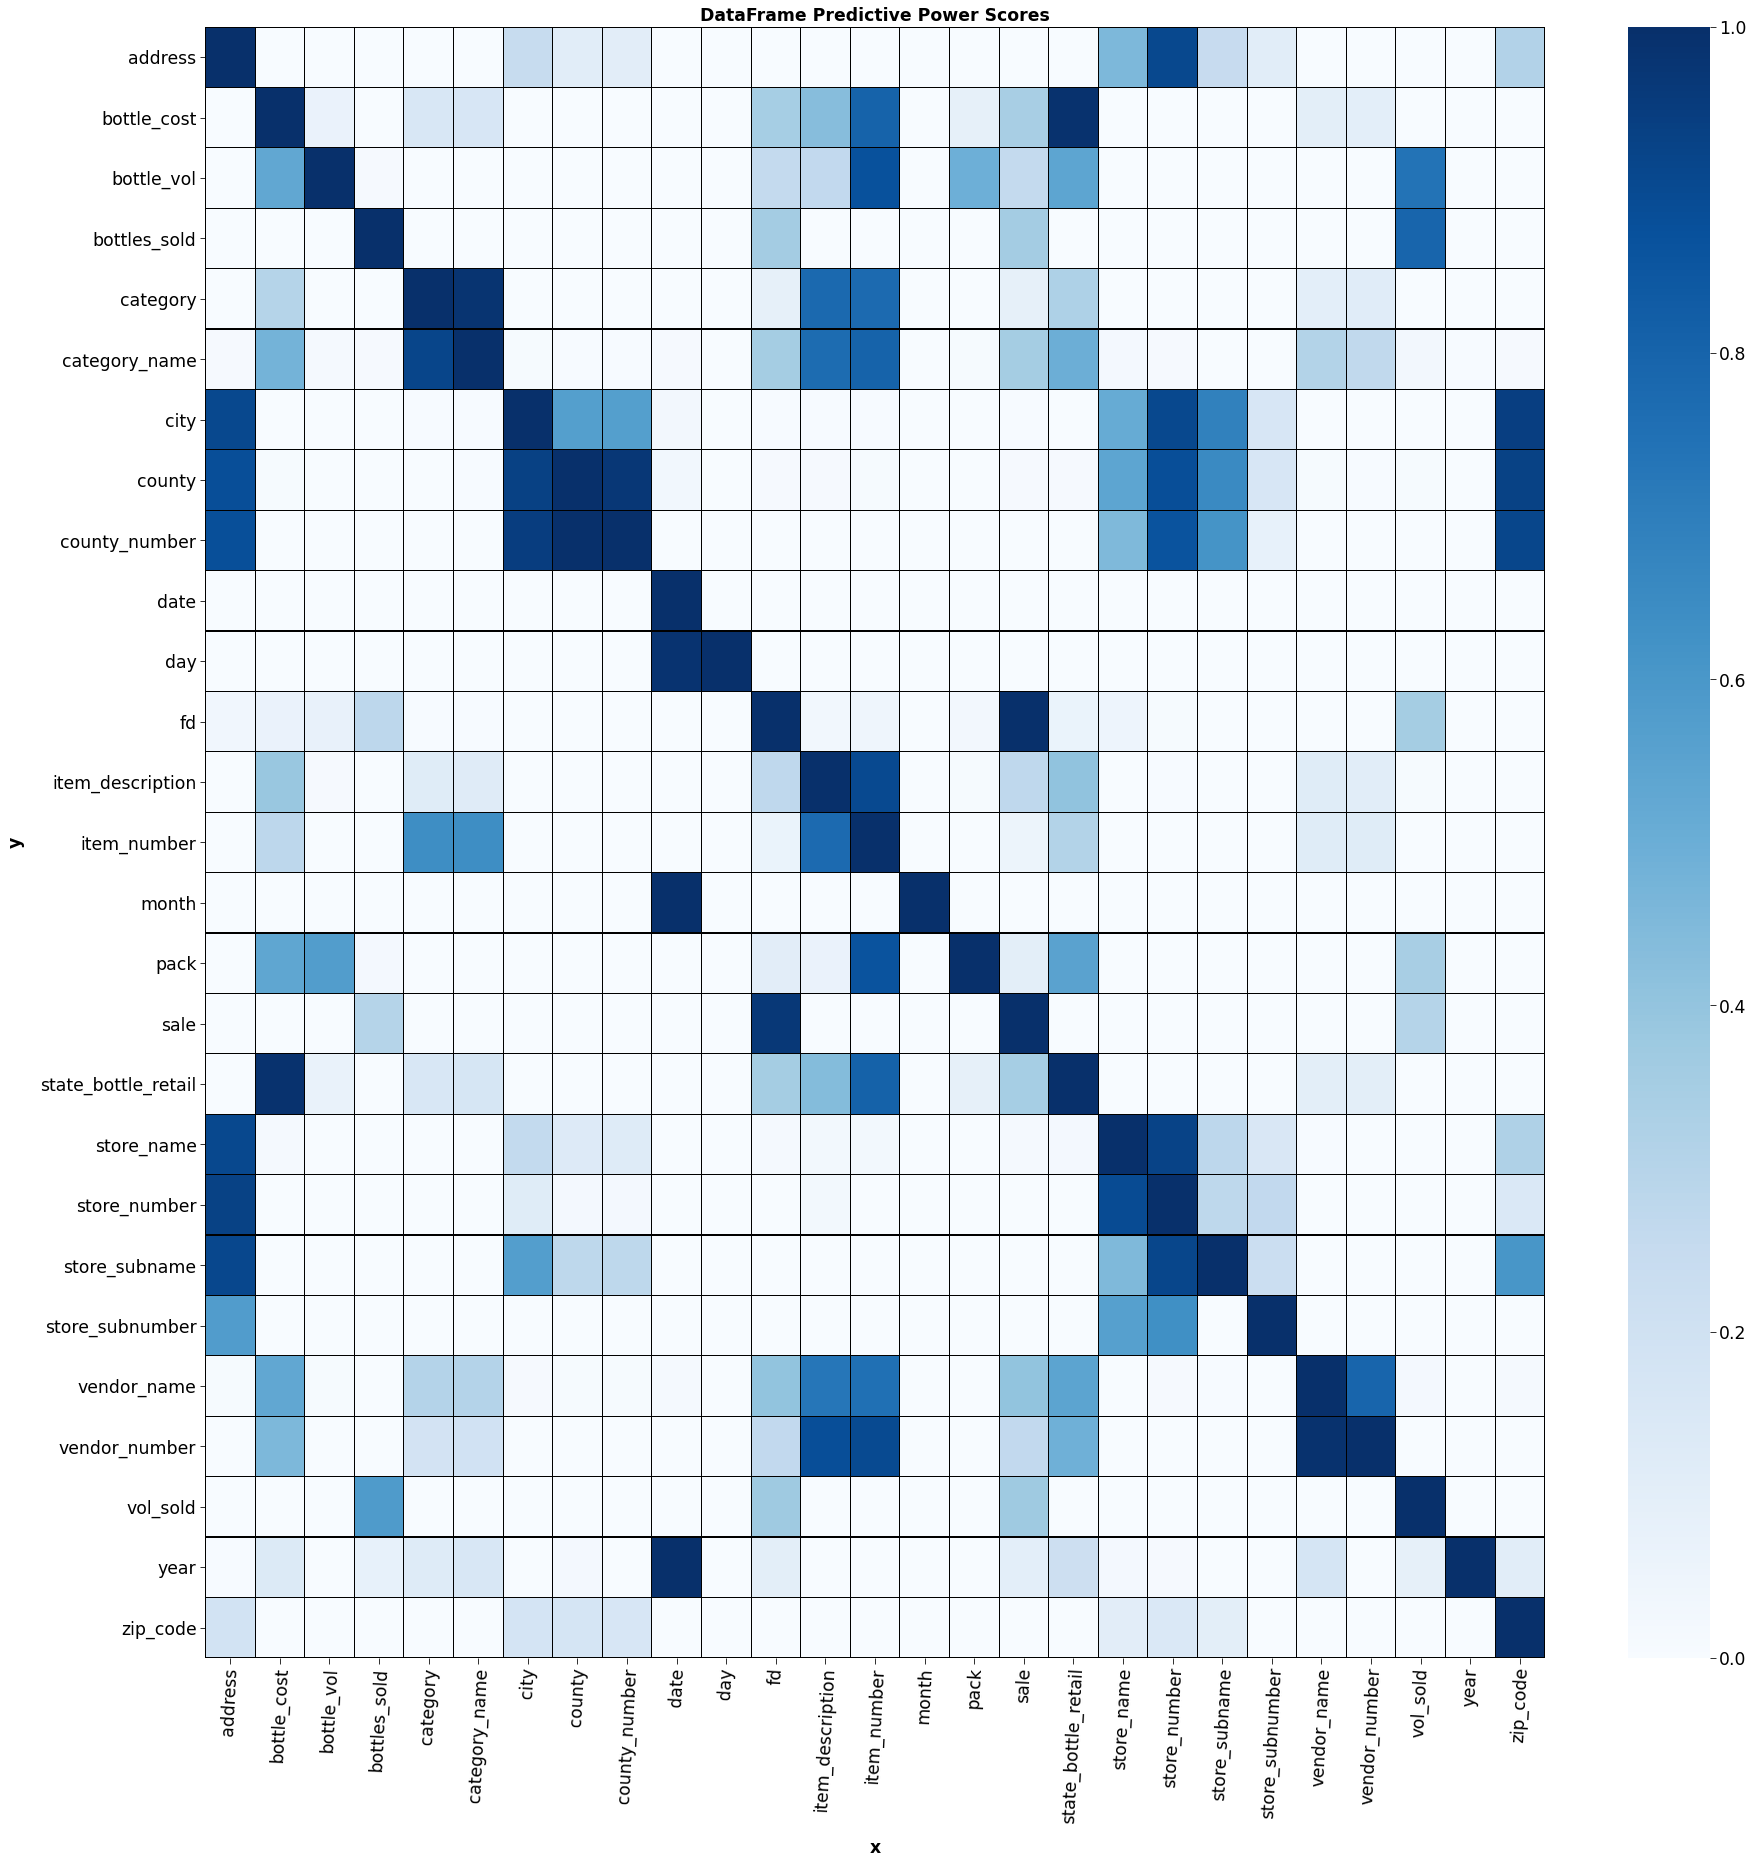

In [68]:
_ = plt.figure(figsize=(30, 30))
_ = sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.1, linecolor='k')
_ = plt.title('DataFrame Predictive Power Scores')
_ = plt.xticks(rotation=87)

In [80]:
df_pps = pps.matrix(df)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

In [89]:
df_pps.query('x == "sale" & ppscore > 0.1').sort_values(by=['ppscore'],ascending=False)#[2:]

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
616,sale,sale,1.000000,predict_itself,True,None,0.000000,1.000000,None
617,sale,fd,0.998793,regression,True,mean absolute error,0.992467,0.001198,DecisionTreeRegressor()
608,sale,vendor_name,0.404437,classification,True,weighted F1,0.062200,0.441481,DecisionTreeClassifier()
618,sale,vol_sold,0.372296,regression,True,mean absolute error,6.077866,3.815099,DecisionTreeRegressor()
615,sale,bottles_sold,0.357024,regression,True,mean absolute error,6.084400,3.912124,DecisionTreeRegressor()
606,sale,category_name,0.354208,classification,True,weighted F1,0.037200,0.378231,DecisionTreeClassifier()
614,sale,state_bottle_retail,0.348266,regression,True,mean absolute error,6.379798,4.157932,DecisionTreeRegressor()
613,sale,bottle_cost,0.347231,regression,True,mean absolute error,4.250058,2.774308,DecisionTreeRegressor()
610,sale,item_description,0.272389,classification,True,weighted F1,0.004800,0.275881,DecisionTreeClassifier()
607,sale,vendor_number,0.263051,regression,True,mean absolute error,114.848000,84.637165,DecisionTreeRegressor()


In [90]:
df_pps.query('y == "sale" & ppscore > 0.1').sort_values(by=['ppscore'],ascending=False)#[2:]

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
616,sale,sale,1.000000,predict_itself,True,None,0.000000,1.000000,None
643,fd,sale,0.968598,regression,True,mean absolute error,89.076022,2.797130,DecisionTreeRegressor()
589,bottles_sold,sale,0.304367,regression,True,mean absolute error,89.076022,61.964185,DecisionTreeRegressor()
670,vol_sold,sale,0.303635,regression,True,mean absolute error,89.076022,62.029408,DecisionTreeRegressor()


### The sale column predicts many values; it has high predictive value. Only two values, however, (bottles_sold and vol_sold) significantly predict the sale amount.

In [129]:
file = '/Users/charisameeker/Documents/Data/iowa_liquor_clean2.pkl'
df.to_pickle(file)